### Read the csv file into a dataframe

In [46]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

beacon_df = pd.read_csv('..\data\\beacon_events_train.csv')

In [47]:
beacon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   event_id             10000 non-null  object 
 1   host_id              10000 non-null  object 
 2   timestamp            10000 non-null  object 
 3   src_ip               10000 non-null  object 
 4   dst_ip               10000 non-null  object 
 5   dst_port             10000 non-null  int64  
 6   protocol             10000 non-null  object 
 7   bytes_out            10000 non-null  int64  
 8   bytes_in             10000 non-null  int64  
 9   inter_event_seconds  9500 non-null   float64
 10  proc_name            10000 non-null  object 
 11  user                 10000 non-null  object 
 12  country_code         10000 non-null  object 
 13  signed_binary        10000 non-null  int64  
 14  label                10000 non-null  int64  
dtypes: float64(1), int64(5), object(9)
me

In [48]:
print(beacon_df.head())

        event_id   host_id            timestamp          src_ip  \
0  EVT-373857567  HOST-116  2025-02-02 19:44:31  192.168.59.229   
1  EVT-380924157  HOST-028  2025-02-06 06:39:00   10.184.88.189   
2  EVT-674957844  HOST-055  2025-02-07 19:08:52  192.168.220.53   
3  EVT-910824095  HOST-107  2025-02-01 12:51:28   10.182.26.253   
4  EVT-959358092  HOST-008  2025-02-01 12:44:21   10.144.27.253   

          dst_ip  dst_port protocol  bytes_out  bytes_in  inter_event_seconds  \
0   30.22.199.92        53      dns       7883      3178            60.970370   
1   214.88.35.75        80      tcp       4905     33319           364.783584   
2   122.183.77.3       443    https       6785      3914            85.435310   
3  221.107.37.31       443    https       2694      3732            76.606740   
4   99.43.113.49       443    https       3379       824            78.295573   

        proc_name     user country_code  signed_binary  label  
0    rundll32.exe  user032           JP       

In [49]:
columns_to_groupby = ['src_ip', 'dst_ip', 'dst_port', 'protocol']

In [50]:
print(beacon_df.groupby(['src_ip', 'dst_ip']).size())

src_ip          dst_ip        
10.0.10.228     196.207.88.24     1
10.0.110.147    131.217.4.156     1
10.0.110.194    197.77.251.72     1
10.0.115.192    78.90.45.48       1
10.0.16.146     105.79.246.101    1
                                 ..
192.168.99.194  192.238.136.24    1
192.168.99.221  161.0.173.11      1
192.168.99.231  147.4.31.233      1
192.168.99.33   113.153.8.204     1
192.168.99.75   25.216.7.184      1
Length: 10000, dtype: int64


In [51]:
print(len(beacon_df[['src_ip', 'dst_ip']].drop_duplicates()))

10000


In [52]:
beacon_df['timestamp'] = pd.to_datetime(beacon_df['timestamp'])

#### Clean the dataset by handling values that are missing or Null or NaN

In [53]:
# Check for missing values
beacon_df.isnull().sum()


event_id                 0
host_id                  0
timestamp                0
src_ip                   0
dst_ip                   0
dst_port                 0
protocol                 0
bytes_out                0
bytes_in                 0
inter_event_seconds    500
proc_name                0
user                     0
country_code             0
signed_binary            0
label                    0
dtype: int64

##### Since the histogram of `inter_event_seconds` has data distribution that shows a marked regularity of linearly decreasing frequency of interval time, we can use the median of the `inter_event_seconds` to fill the missing values in the dataset.

In [54]:
beacon_df['inter_event_seconds'] = beacon_df['inter_event_seconds'].fillna(beacon_df['inter_event_seconds'].median())

In [55]:
# Check the statistics of the numerical columns
beacon_df.describe()

,timestamp,dst_port,bytes_out,bytes_in,inter_event_seconds,signed_binary,label
count,10000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,2025-02-04 11:53:53.872399872,7604.64060,20236.961000,23732.677200,475.668170,0.709500,0.223600
min,2025-02-01 00:00:01,53.00000,50.000000,52.000000,1.000000,0.000000,0.000000
25%,2025-02-02 17:54:03.750000128,443.00000,5739.500000,3653.750000,72.712647,0.000000,0.000000
50%,2025-02-04 11:51:58.500000,993.00000,17705.000000,21152.000000,269.569736,1.000000,0.000000
75%,2025-02-06 06:12:48.500000,8080.00000,33852.500000,40798.750000,665.510421,1.000000,0.000000
max,2025-02-07 23:59:49,65519.00000,49999.000000,59968.000000,6163.562442,1.000000,1.000000
std,NaN,13977.50932,15387.376367,19214.979265,568.406887,0.454016,0.416678


In [56]:
## DELETE this cell
beacon_df['label'].value_counts()

label
0    7764
1    2236
Name: count, dtype: int64

In [57]:
features = beacon_df.groupby(['src_ip', 'dst_ip']).agg({
    'inter_event_seconds': ['mean', 'std', 'var'],
    'bytes_out': ['mean', 'std'],
    'timestamp': 'count'
}).fillna(0)

print(features)

                              inter_event_seconds           bytes_out       \
                                             mean  std  var      mean  std   
src_ip         dst_ip                                                        
10.0.10.228    196.207.88.24           760.334344  0.0  0.0   44970.0  0.0   
10.0.110.147   131.217.4.156           412.242410  0.0  0.0   40093.0  0.0   
10.0.110.194   197.77.251.72           216.096210  0.0  0.0   25531.0  0.0   
10.0.115.192   78.90.45.48             900.230563  0.0  0.0    7961.0  0.0   
10.0.16.146    105.79.246.101          848.677722  0.0  0.0   22230.0  0.0   
...                                           ...  ...  ...       ...  ...   
192.168.99.194 192.238.136.24           85.176169  0.0  0.0    4363.0  0.0   
192.168.99.221 161.0.173.11            269.569736  0.0  0.0    1300.0  0.0   
192.168.99.231 147.4.31.233            550.426032  0.0  0.0    7788.0  0.0   
192.168.99.33  113.153.8.204            62.779336  0.0  0.0    3

#### There are 6 numerical features
```mermaid
-   Destination Port
-   Bytes Out
-   Bytes In
-   Inter event Seconds
-   Signed Binary
```

#### There are 9 categorical features
```mermaid
-   event_id
-   host_id
-   timestamp
-   Source IP
-   Destination IP
-   Protocol
-   Process name
-   User
-   Country Code
```

#### EDA of numerical features

##### 1)    Inter Event Seconds EDA

In [58]:
##### inter_event_seconds
beacon_df['inter_event_seconds'].describe()

count    10000.000000
mean       475.668170
std        568.406887
min          1.000000
25%         72.712647
50%        269.569736
75%        665.510421
max       6163.562442
Name: inter_event_seconds, dtype: float64

##### While the minimum value of inter event seconds is 1 sec, mean is 486.51 seconds, 50% of the data lies with 269 seconds. Lets plot the distrubution

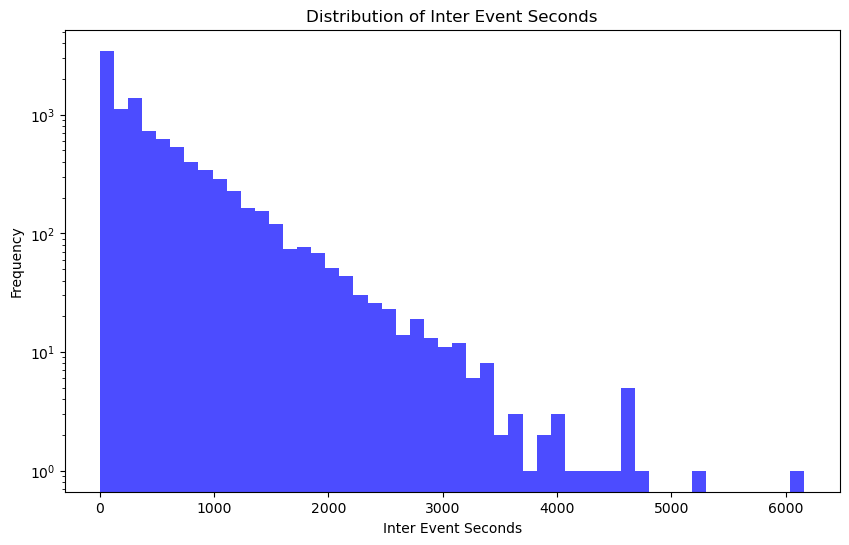

In [59]:
plt.figure(figsize=(10,6))
plt.hist(beacon_df['inter_event_seconds'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Inter Event Seconds')
plt.xlabel('Inter Event Seconds')
plt.ylabel('Frequency')
plt.yscale('log')

plt.show()

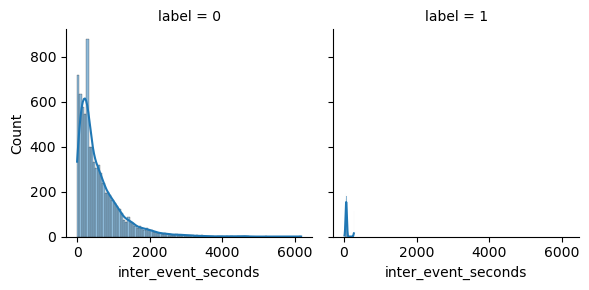

In [60]:
fg = sns.FacetGrid(data=beacon_df, col='label')
fg.map(sns.histplot, 'inter_event_seconds', kde=True)
plt.show()

##### Plot the boxplot for the inter_event_seconds v/s labels to get an understanding of the outliers

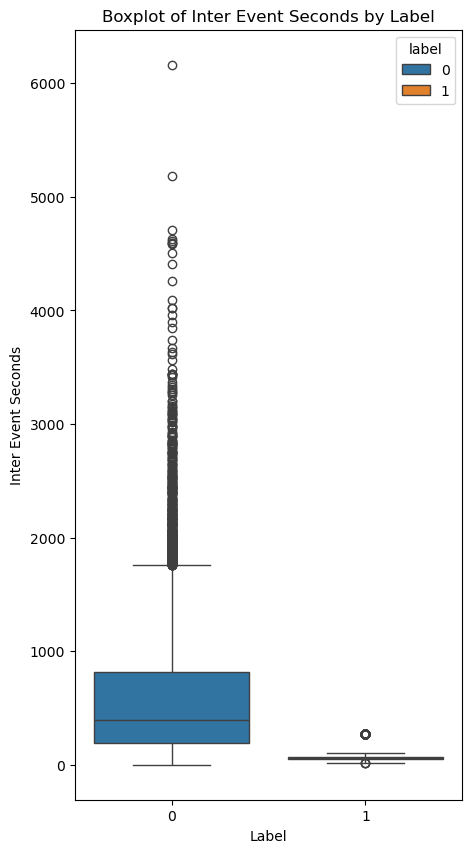

In [61]:
plt.figure(figsize=(5, 10))
sns.boxplot(x='label', y='inter_event_seconds', data=beacon_df[['inter_event_seconds', 'label']], hue='label')
plt.title('Boxplot of Inter Event Seconds by Label')
plt.xlabel('Label')
plt.ylabel('Inter Event Seconds')
plt.show()

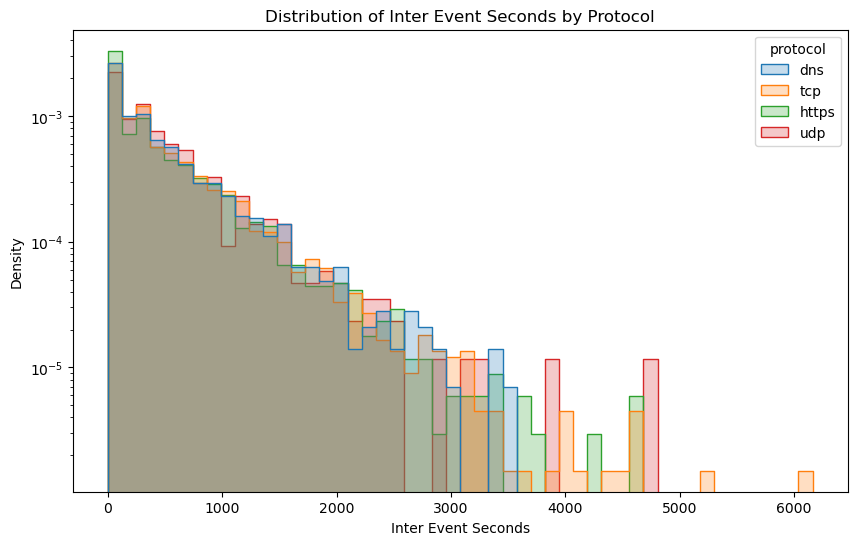

In [62]:
# Draw distribution plot for inter_event_seconds based on protocol type
plt.figure(figsize=(10,6))
sns.histplot(data=beacon_df, x='inter_event_seconds', hue='protocol', element='step', stat='density', common_norm=False, bins=50)
plt.title('Distribution of Inter Event Seconds by Protocol')
plt.xlabel('Inter Event Seconds')
plt.ylabel('Density')
plt.yscale('log')
plt.show()

##### 2)    Destination Port EDA

1567


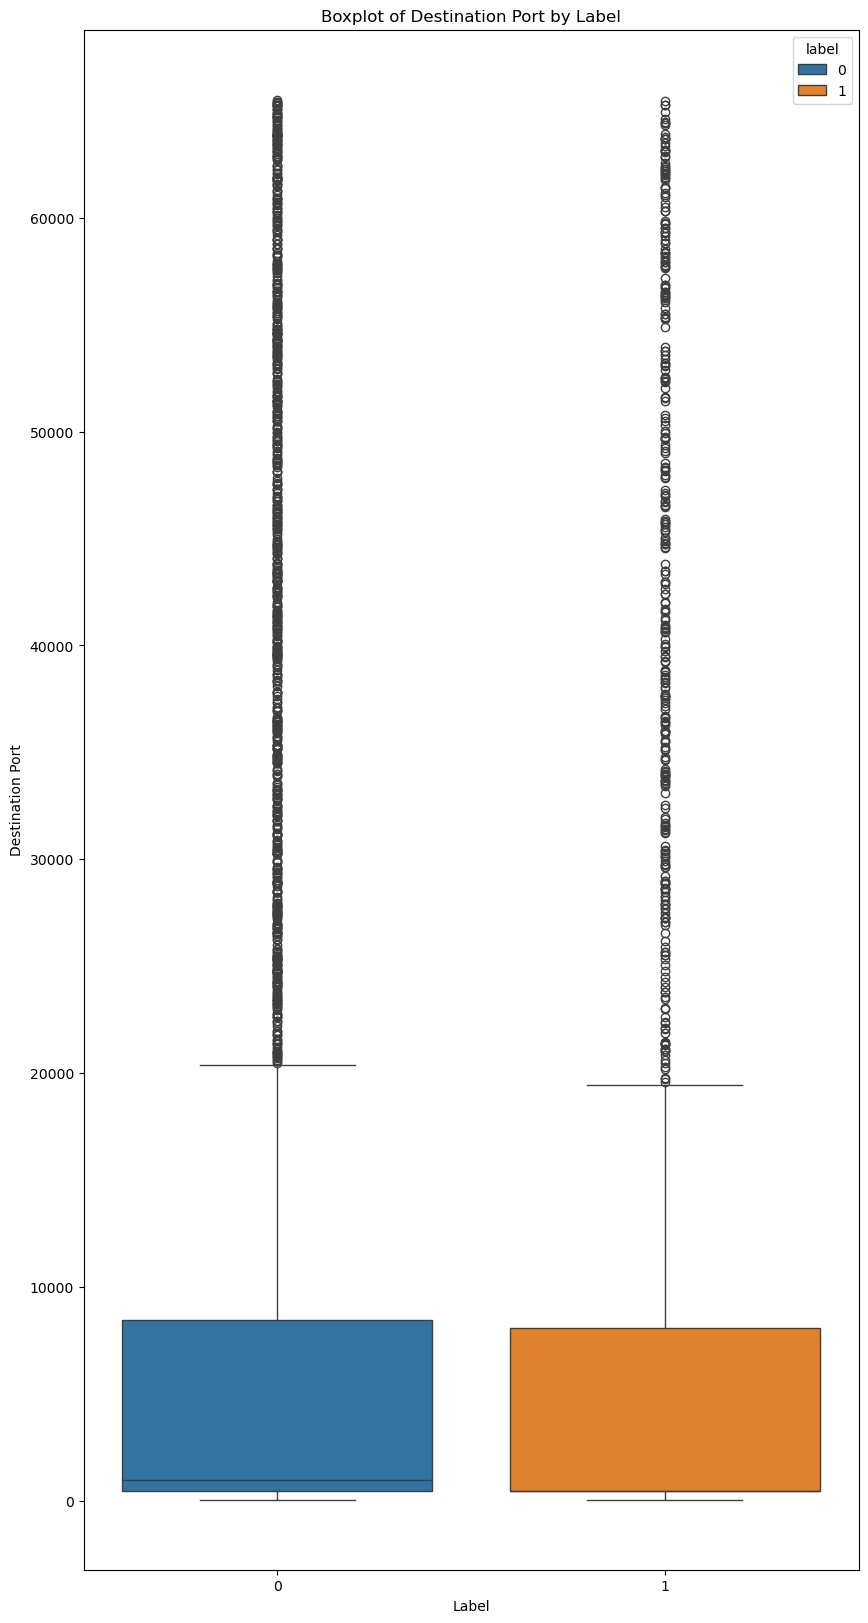

In [63]:
## Boxplot feature versus labels

print(beacon_df['dst_port'].nunique())

df_dst_port = beacon_df[['dst_port', 'label']]

plt.figure(figsize=(10, 20))
sns.boxplot(x='label', y='dst_port', data=df_dst_port, hue='label')
plt.title('Boxplot of Destination Port by Label')
plt.xlabel('Label')
plt.ylabel('Destination Port')
plt.show()

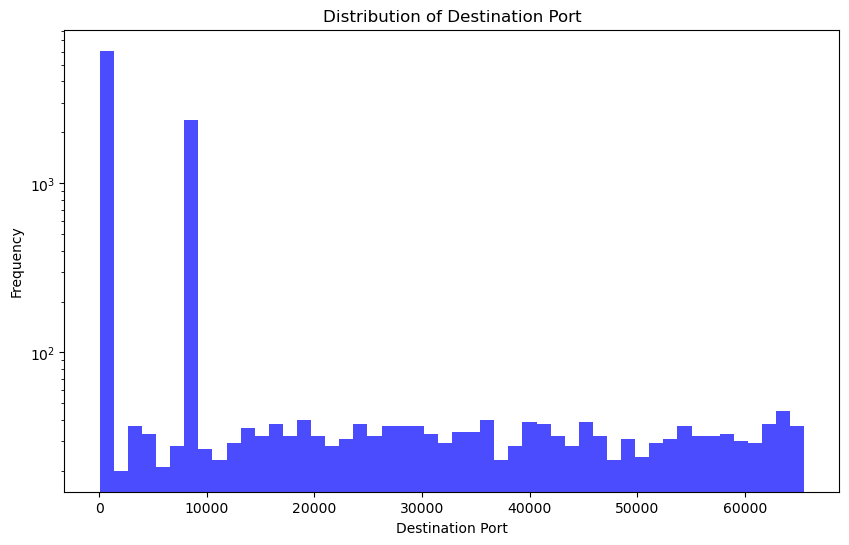

In [64]:
plt.figure(figsize=(10,6))
plt.hist(beacon_df['dst_port'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Destination Port')
plt.xlabel('Destination Port')
plt.ylabel('Frequency')
plt.yscale('log')

plt.show()

In [65]:
import numpy as np

group_dst_port = beacon_df[['dst_port', 'label']].copy()
group_dst_port.groupby(['dst_port', 'label'])['label'].count()

dst_port  label
53        0        926
          1        237
80        0        945
          1        228
443       0        954
                  ... 
65382     0          1
65391     0          1
65409     0          1
65461     1          1
65519     0          1
Name: label, Length: 1577, dtype: int64

##### 3)    Bytes In EDA

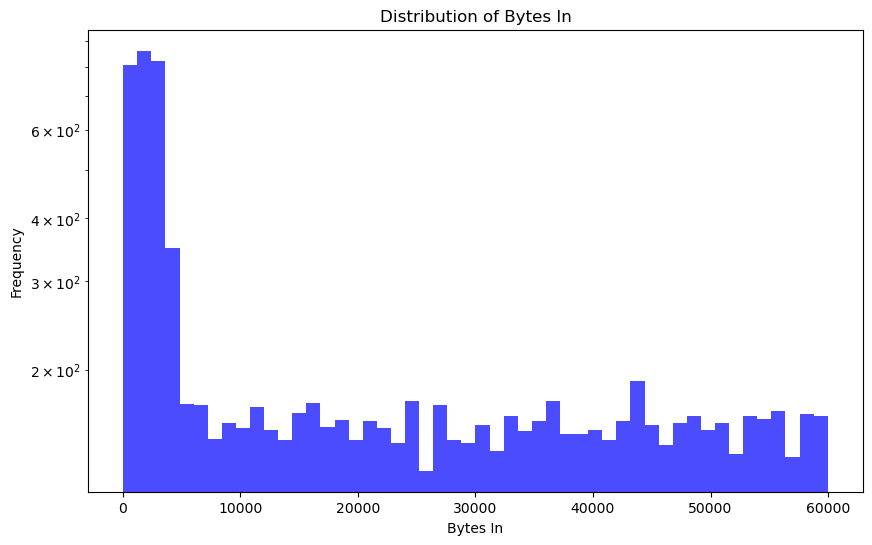

In [66]:
plt.figure(figsize=(10,6))
plt.hist(beacon_df['bytes_in'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Bytes In')
plt.xlabel('Bytes In')
plt.ylabel('Frequency')
plt.yscale('log')

plt.show()

8796


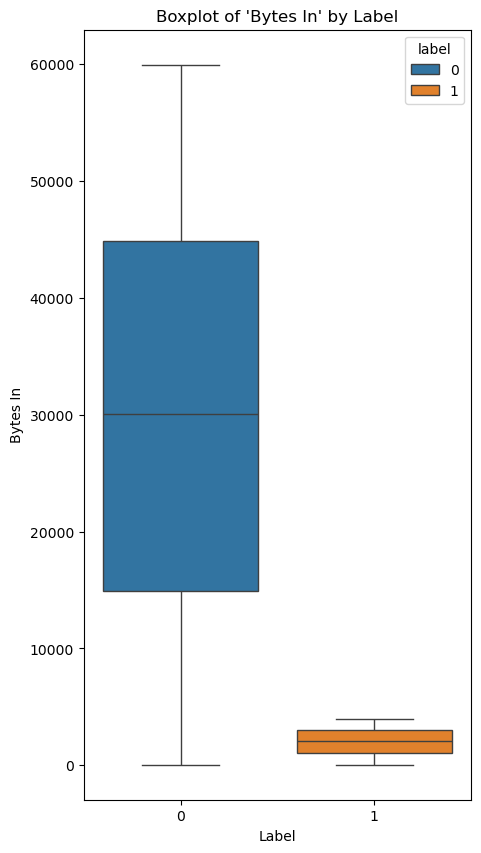

In [67]:
print(beacon_df['bytes_in'].nunique())

df_dst_port = beacon_df[['bytes_in', 'label']]

plt.figure(figsize=(5, 10))
sns.boxplot(x='label', y='bytes_in', data=df_dst_port, hue='label')
plt.title('Boxplot of \'Bytes In\' by Label')
plt.xlabel('Label')
plt.ylabel('Bytes In')
plt.show()

##### 4)    Bytes Out EDA

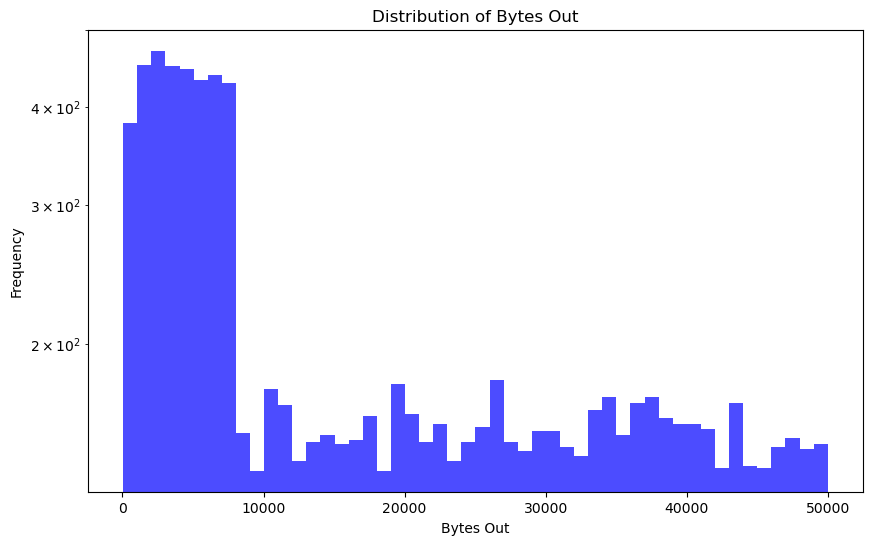

In [68]:
plt.figure(figsize=(10,6))
plt.hist(beacon_df['bytes_out'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Bytes Out')
plt.xlabel('Bytes Out')
plt.ylabel('Frequency')
plt.yscale('log')

plt.show()

8893


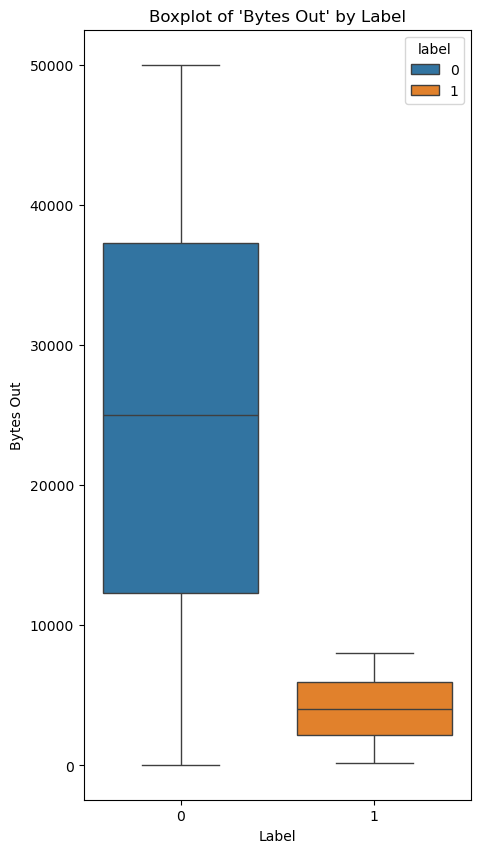

In [69]:
print(beacon_df['bytes_out'].nunique())

df_dst_port = beacon_df[['bytes_out', 'label']]

plt.figure(figsize=(5, 10))
sns.boxplot(x='label', y='bytes_out', data=df_dst_port, hue='label')
plt.title('Boxplot of \'Bytes Out\' by Label')
plt.xlabel('Label')
plt.ylabel('Bytes Out')
plt.show()

#### Exploratory data Analysis of categorical variables.

In [70]:
beacon_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   event_id             10000 non-null  object        
 1   host_id              10000 non-null  object        
 2   timestamp            10000 non-null  datetime64[ns]
 3   src_ip               10000 non-null  object        
 4   dst_ip               10000 non-null  object        
 5   dst_port             10000 non-null  int64         
 6   protocol             10000 non-null  object        
 7   bytes_out            10000 non-null  int64         
 8   bytes_in             10000 non-null  int64         
 9   inter_event_seconds  10000 non-null  float64       
 10  proc_name            10000 non-null  object        
 11  user                 10000 non-null  object        
 12  country_code         10000 non-null  object        
 13  signed_binary        10000 non-n

##### 4)    `Country Code` EDA

In [71]:
# Country code analysis
print(f'Total number of countries: {beacon_df["country_code"].nunique()}')
# Display the count of records per country code
print(beacon_df.value_counts('country_code'))

Total number of countries: 18
country_code
US    2160
IN     794
DE     750
CA     750
FR     745
GB     731
NL     717
JP     709
CN     281
RU     276
VN     274
BR     264
UA     264
HK     264
NG     261
TR     258
IR     253
KP     249
Name: count, dtype: int64


In [72]:
import sys
import os

repo_root = os.path.abspath(r'C:\Users\Soumendra\Documents\GitHub\BeaconHunter')
module_path = os.path.join(repo_root, 'src')

if module_path not in sys.path:
    sys.path.append(module_path)

In [73]:
from features import plot_categorial_distribution

plot_categorial_distribution(beacon_df, 'country_code', 'label')

ImportError: cannot import name 'plot_categorial_distribution' from 'features' (C:\Users\Soumendra\Documents\GitHub\BeaconHunter\src\features.py)

##### 5)    `Process Name` EDA

In [ ]:
# Count the occurrences of each process name
df_proc_name = beacon_df.value_counts('proc_name').reset_index()
df_proc_name.columns = ['proc_name', 'count']
df_proc_name['proc_name'] = df_proc_name['proc_name'].str.replace('.exe', '', regex=False)
df_proc_name.head(25)

,proc_name,count
0,firefox,803
1,teams,776
2,zoom,773
3,word,763
4,outlook,759
5,spotify,758
6,slack,748
7,onedrive,747
8,chrome,735
9,excel,724


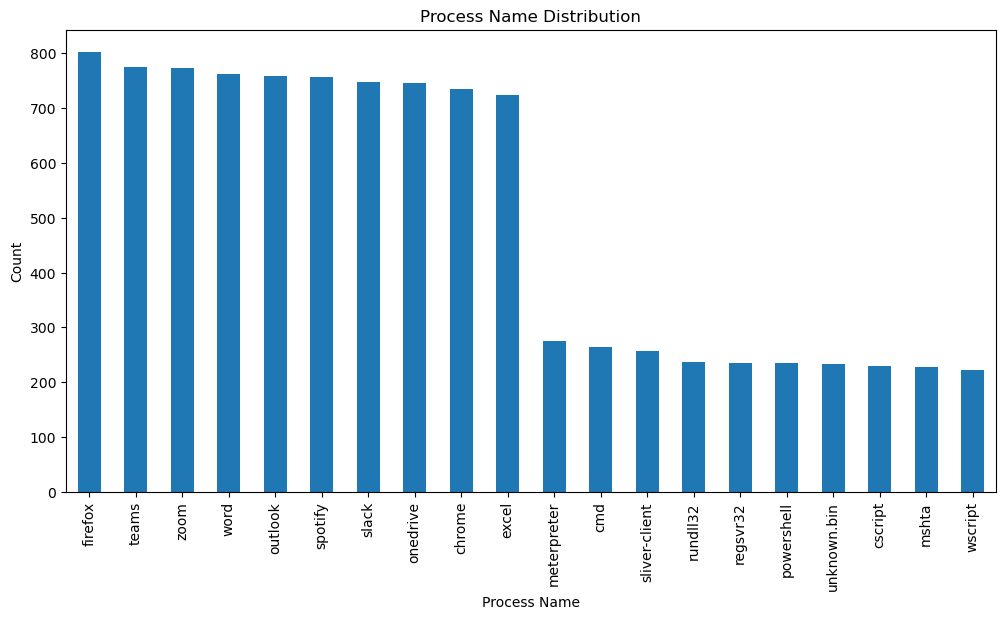

In [ ]:
# Draw bar plot for process name distribution

df_proc_name.plot(kind='bar', x='proc_name', y='count', legend=False, figsize=(12, 6))
plt.title('Process Name Distribution')
plt.xlabel('Process Name')
plt.ylabel('Count')
plt.show()


feature name: proc_name


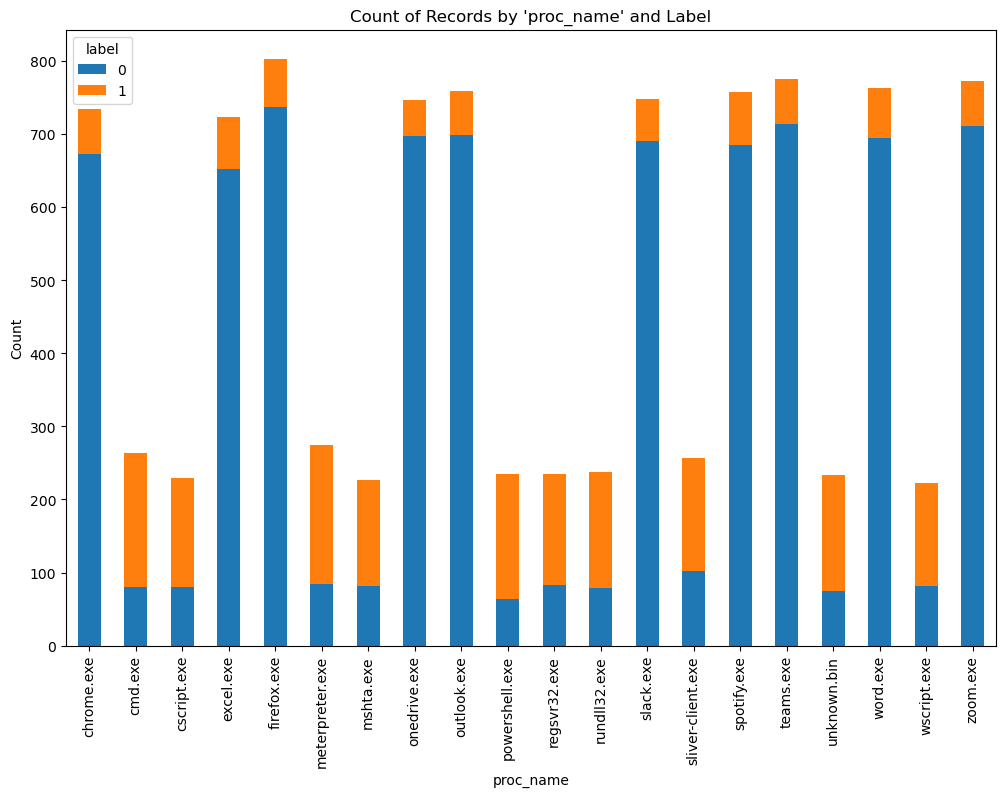

In [ ]:
# Draw bar plot for top 20 process names vesus label

from features import plot_categorial_distribution

plot_categorial_distribution(beacon_df, 'proc_name', 'label')

##### 6)    `Protocol` EDA

feature name: protocol


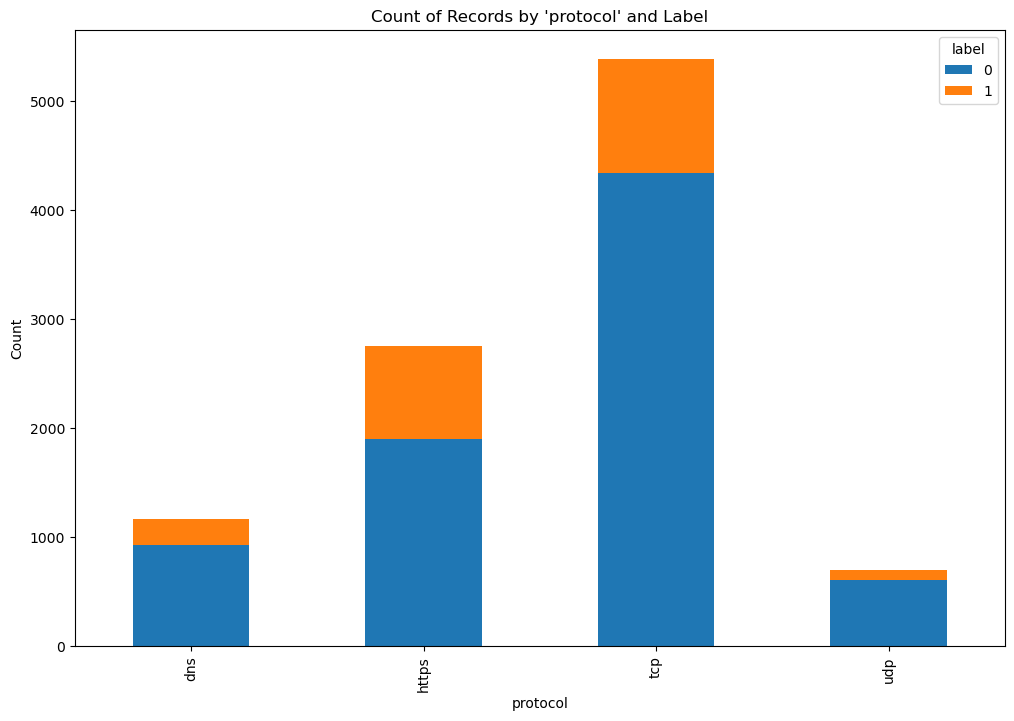

In [ ]:
# Draw bar plot for Protocol used for communication vesus label

from features import plot_categorial_distribution
plot_categorial_distribution(beacon_df, 'protocol', 'label')

##### 6)    `User` EDA

In [ ]:
beacon_df['user'].nunique()

203

##### There are 203 unique users for the 10000 records. Plotting a chart for the user versus the labels will give and idea about the risky and non risky users

In [ ]:
beacon_df['user'].value_counts()

user
svc_antivirus    69
user131          67
user049          66
user116          65
user089          64
                 ..
user106          35
user039          35
user095          33
user081          32
user161          29
Name: count, Length: 203, dtype: int64

feature name: user


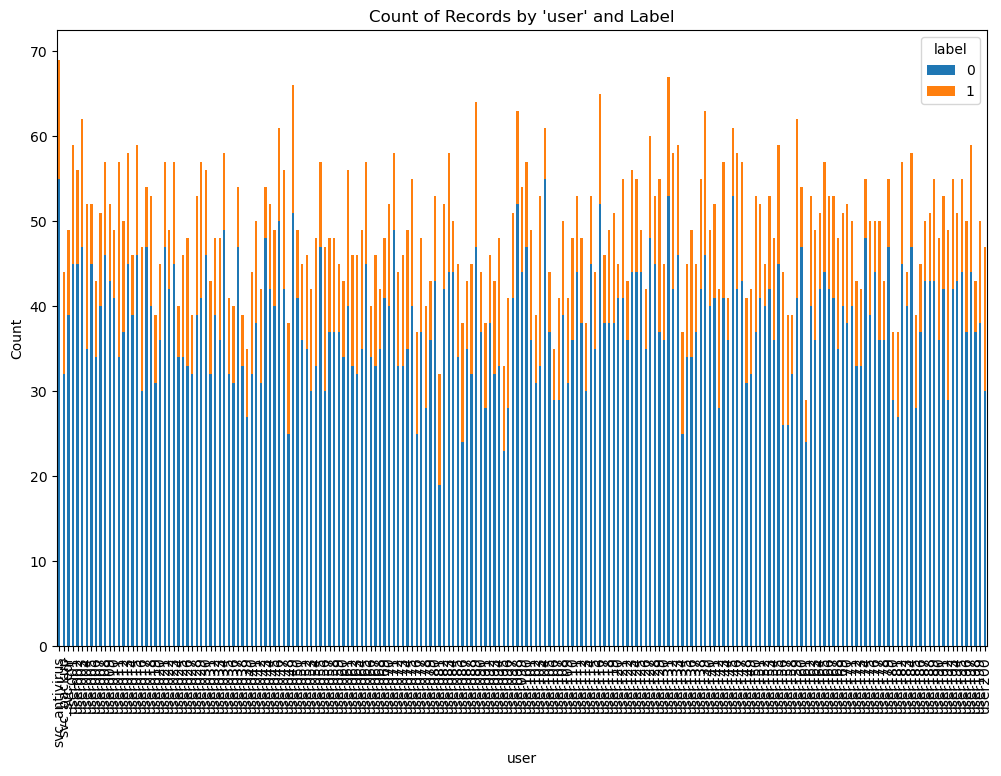

In [ ]:
# Draw bar plot for Protocol used for communication vesus label

from features import plot_categorial_distribution
plot_categorial_distribution(beacon_df, 'user', 'label')

#### 7)  Common port distribution

Text(0, 0.5, 'Count')

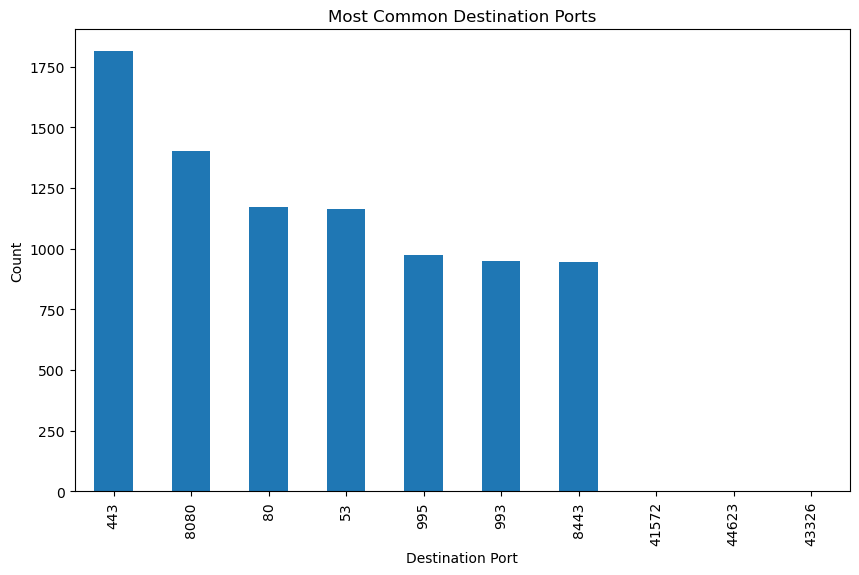

In [ ]:
# draw bar plot for most common 10 dst_port

plt.figure(figsize=(10,6))
common_ports = beacon_df['dst_port'].value_counts()[:10]
common_ports.plot(kind='bar')
plt.title('Most Common Destination Ports')
plt.xlabel('Destination Port')
plt.ylabel('Count')

#### 1.2  Derieved feature - Beaconness
A. Formulate a derieved feature named Beaconness that gives an idea about the variance of `inter_event_seconds` per `host_id/dest_ip` combination

In [ ]:
stats = beacon_df.groupby(['host_id', 'dst_ip'])['inter_event_seconds'].agg(['mean', 'std', 'var', 'count'])
stats

mean  std  var  count
host_id  dst_ip                                     
HOST-001 101.162.231.37   37.987781  NaN  NaN      1
         102.81.243.35   150.433381  NaN  NaN      1
         104.230.86.80    76.597194  NaN  NaN      1
         104.53.97.30    390.204522  NaN  NaN      1
         109.128.37.138  888.037706  NaN  NaN      1
...                             ...  ...  ...    ...
HOST-150 85.251.2.163     57.012152  NaN  NaN      1
         87.102.105.201  781.040262  NaN  NaN      1
         87.250.109.1     65.845316  NaN  NaN      1
         88.220.45.55     57.311753  NaN  NaN      1
         97.67.229.66     50.666034  NaN  NaN      1

[10000 rows x 4 columns]

The dataset is very limited for assessing a combination of host_id and dst_ip pair based inter_event_seconds, as we can see that there are 10000 unique combinations of the host_id/dst_ip pairs. So beaconness based on this combination will not give us a meaningful statistics to analyze the variance for this dataset. Instaed we group the dataset based on `host_id` and distribute the variance in a new column named `baconness`.

In [ ]:
# create derieved feature based on variance of inter_event_seconds per host_id, dst_port
beacon_df['beaconness'] = beacon_df.groupby(['host_id', 'dst_port'])['inter_event_seconds'].transform(lambda x: x.var()).fillna(0)

In [ ]:
beacon_df.head(100)

,event_id,host_id,timestamp,src_ip,dst_ip,dst_port,protocol,bytes_out,bytes_in,inter_event_seconds,proc_name,user,country_code,signed_binary,label,beaconness
0,EVT-373857567,HOST-116,2025-02-02 19:44:31,192.168.59.229,30.22.199.92,53,dns,7883,3178,60.970370,rundll32.exe,user032,JP,0,1,1.448488e+05
1,EVT-380924157,HOST-028,2025-02-06 06:39:00,10.184.88.189,214.88.35.75,80,tcp,4905,33319,364.783584,spotify.exe,user179,FR,1,0,5.294039e+05
2,EVT-674957844,HOST-055,2025-02-07 19:08:52,192.168.220.53,122.183.77.3,443,https,6785,3914,85.435310,excel.exe,user121,JP,0,1,1.947371e+05
3,EVT-910824095,HOST-107,2025-02-01 12:51:28,10.182.26.253,221.107.37.31,443,https,2694,3732,76.606740,powershell.exe,user063,DE,0,1,2.771213e+05
4,EVT-959358092,HOST-008,2025-02-01 12:44:21,10.144.27.253,99.43.113.49,443,https,3379,824,78.295573,mshta.exe,user195,NG,0,1,3.800378e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,EVT-854404467,HOST-010,2025-02-04 08:50:23,10.109.86.37,86.247.189.69,995,tcp,34985,37287,350.208665,chrome.exe,user197,IN,1,0,1.195202e+05
96,EVT-204417594,HOST-060,2025-02-05 05:46:10,10.246.67.184,46.129.117.77,8080,tcp,40141,43109,183.170699,outlook.exe,user072,GB,1,0,2.023428e+05
97,EVT-546772890,HOST-023,2025-02-05 21:11:28,10.246.168.36,197.28.237.133,993,tcp,7712,3347,380.679553,outlook.exe,user187,IN,1,0,1.999277e+05
98,EVT-176093013,HOST-084,2025-02-04 12:01:43,10.9.244.240,99.160.77.14,443,https,23147,43410,519.804421,onedrive.exe,user152,GB,0,0,1.086318e+05


B. Formulate a derieved feature named `Weiredness` that gives a distribution about most common occurances of `destination ports` as compared to rare ports. The feature is classifies as per frequency of the top ports as shown below. The classification is 'common' and 'rare'

In [ ]:
## Create derived features based on dst_port common vs rare ports
common_ports = [80, 443, 53, 8080, 8443, 993, 995]
beacon_df['wierdness'] = beacon_df['dst_port'].apply(lambda x: 'common' if x in common_ports else 'rare')
beacon_df.head()


,event_id,host_id,timestamp,src_ip,dst_ip,dst_port,protocol,bytes_out,bytes_in,inter_event_seconds,proc_name,user,country_code,signed_binary,label,beaconness,wierdness
0,EVT-373857567,HOST-116,2025-02-02 19:44:31,192.168.59.229,30.22.199.92,53,dns,7883,3178,60.970370,rundll32.exe,user032,JP,0,1,144848.819925,common
1,EVT-380924157,HOST-028,2025-02-06 06:39:00,10.184.88.189,214.88.35.75,80,tcp,4905,33319,364.783584,spotify.exe,user179,FR,1,0,529403.920508,common
2,EVT-674957844,HOST-055,2025-02-07 19:08:52,192.168.220.53,122.183.77.3,443,https,6785,3914,85.435310,excel.exe,user121,JP,0,1,194737.076773,common
3,EVT-910824095,HOST-107,2025-02-01 12:51:28,10.182.26.253,221.107.37.31,443,https,2694,3732,76.606740,powershell.exe,user063,DE,0,1,277121.275738,common
4,EVT-959358092,HOST-008,2025-02-01 12:44:21,10.144.27.253,99.43.113.49,443,https,3379,824,78.295573,mshta.exe,user195,NG,0,1,380037.828343,common


C. Formulate a derieved feature named `process_risk` that gives captures the risk score of the risly processes based on intuition and reasearch statistics. Based on reasearch processes that are high risk are `explorere.exe, svchost.exe, lsass.exe, taskhostw.exe`. Since these processes are not listed in the training data, we will draw inference of the process risk based on the bar diagram where each process `proc_name` is mapped to label with 0 and 1 in the training data.

We will take the ratio of the process's count based on 0 and 1 in their label and create a derieved feature which will be used for training.

In [ ]:
# Create derived feature based on risk of process names 
high_risk_processes = ['powershell.exe', 'cmd.exe', 'wmic.exe', 'cscript.exe', 'wscript.exe', 'regsvr32.exe']
beacon_df['proc_risk'] = beacon_df['proc_name'].apply(lambda x: 'high' if x in high_risk_processes else 'low')
beacon_df.head()

,event_id,host_id,timestamp,src_ip,dst_ip,dst_port,protocol,bytes_out,bytes_in,inter_event_seconds,proc_name,user,country_code,signed_binary,label,beaconness,wierdness,proc_risk
0,EVT-373857567,HOST-116,2025-02-02 19:44:31,192.168.59.229,30.22.199.92,53,dns,7883,3178,60.970370,rundll32.exe,user032,JP,0,1,144848.819925,common,low
1,EVT-380924157,HOST-028,2025-02-06 06:39:00,10.184.88.189,214.88.35.75,80,tcp,4905,33319,364.783584,spotify.exe,user179,FR,1,0,529403.920508,common,low
2,EVT-674957844,HOST-055,2025-02-07 19:08:52,192.168.220.53,122.183.77.3,443,https,6785,3914,85.435310,excel.exe,user121,JP,0,1,194737.076773,common,low
3,EVT-910824095,HOST-107,2025-02-01 12:51:28,10.182.26.253,221.107.37.31,443,https,2694,3732,76.606740,powershell.exe,user063,DE,0,1,277121.275738,common,high
4,EVT-959358092,HOST-008,2025-02-01 12:44:21,10.144.27.253,99.43.113.49,443,https,3379,824,78.295573,mshta.exe,user195,NG,0,1,380037.828343,common,low



'''proc_name_df = beacon_df.groupby(['proc_name', 'label'], as_index=False).agg(
        Count=('label', 'count')
    )


proc_name_df['sum'] = proc_name_df.groupby('proc_name')['Count'].transform('sum')
proc_name_df['proc_label_prop'] = proc_name_df['Count'] / proc_name_df['sum']
proc_name_df.drop(columns=['Count', 'sum'], inplace=True)
proc_name_df.set_index(['proc_name', 'label'])
beacon_df = pd.merge(beacon_df, proc_name_df, on=['proc_name', 'label'], how='right')
'''

D. Implement GeoIP risk score feature based on country_code

In [ ]:
# Create derieved feature from country code risk level
country_risk_mapping = {
    "BR": 1,
    "CN": 1,
    "HK": 1,
    "IR": 1,
    "KP": 1,
    "NG": 1,
    "RU": 1,
    "TR": 1,
    "UA": 1,
    "VN":  1
}
beacon_df['geoip_risk'] = beacon_df['country_code'].map(country_risk_mapping).fillna(0)

In [ ]:
beacon_df.isnull().sum()

event_id               0
host_id                0
timestamp              0
src_ip                 0
dst_ip                 0
dst_port               0
protocol               0
bytes_out              0
bytes_in               0
inter_event_seconds    0
proc_name              0
user                   0
country_code           0
signed_binary          0
label                  0
beaconness             0
dtype: int64

In [ ]:
beacon_df.head()

,event_id,host_id,timestamp,src_ip,dst_ip,dst_port,protocol,bytes_out,bytes_in,inter_event_seconds,proc_name,user,country_code,signed_binary,label,beaconness,geoip_risk
0,EVT-373857567,HOST-116,2025-02-02 19:44:31,192.168.59.229,30.22.199.92,53,dns,7883,3178,60.970370,rundll32.exe,user032,JP,0,1,144848.819925,0.0
1,EVT-380924157,HOST-028,2025-02-06 06:39:00,10.184.88.189,214.88.35.75,80,tcp,4905,33319,364.783584,spotify.exe,user179,FR,1,0,529403.920508,0.0
2,EVT-674957844,HOST-055,2025-02-07 19:08:52,192.168.220.53,122.183.77.3,443,https,6785,3914,85.435310,excel.exe,user121,JP,0,1,194737.076773,0.0
3,EVT-910824095,HOST-107,2025-02-01 12:51:28,10.182.26.253,221.107.37.31,443,https,2694,3732,76.606740,powershell.exe,user063,DE,0,1,277121.275738,0.0
4,EVT-959358092,HOST-008,2025-02-01 12:44:21,10.144.27.253,99.43.113.49,443,https,3379,824,78.295573,mshta.exe,user195,NG,0,1,380037.828343,1.0
